# Transfer Learning

In this colab, we will explore sentiment classification: in particular, we'll see how we can train an "adapter" over BERT embeddings, learning how the semantic information captured by BERT can be used to make predictions about the sentiment (positive or negative) expressed by a sentence.

*IMPORTANT*:

You will have to run this notebook on a GPU. To activate GPU-usage:
1. click 'Runtime'
2. click 'Change runtime type'
3. Select 'GPU' for 'Hardware accelerator' and save

## 0. Import packages

First, run this cell to import all necessary packages (and install them, if necessary). Then, continue with the following cell to load the required data.

In [ ]:
# INSTALL MISSING PACKAGES
from importlib.util import find_spec
import pip

required_packages = ['torch', 'datasets', 'pandas']

for package in required_packages:
  if find_spec(package) is None:
    print(f'Installing package: {package}...')
    pip.main(['install', package])

!pip uninstall transformers
!pip uninstall adapter-transformers
!pip install -U adapter-transformers
!pip install huggingface
!pip install --upgrade datasets

# IMPORT PACKAGES
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

import datasets
from datasets import Dataset, DatasetDict


import transformers
from transformers import BertTokenizer, BertModel
from transformers import pipeline
from transformers import AutoConfig, AutoTokenizer, AutoModelWithHeads, AutoModelForSequenceClassification
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

from transformers import TextClassificationPipeline
from transformers import TrainerCallback

tokenizer = BertTokenizer.from_pretrained('vinai/bertweet-base')
model = BertModel.from_pretrained('vinai/bertweet-base',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Found existing installation: transformers 4.35.2
Uninstalling transformers-4.35.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.35.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.35.2
  Using cached adapter_transformers-3.2.1.post0-py3-none-any.whl (6.4 MB)
  Using cached huggingface_hub-0.13.4-py3-none-any.whl (200 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
ERROR: pip's dependency resolver does not currently take into acc

/usr/local/lib/python3.10/dist-packages/transformers/adapters/__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertweetTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.4.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.self.query.weight', 'roberta.encoder.layer.3.attention.self.query.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.4.attention.self.query.bias', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.encoder.layer.6.attention.self.key.bias', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.bias', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', '

## 1. Load data

Do you remember which is the difference between: **training set**, **validation set** and **test set**?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive'

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
"""train_data = "training_set_tweet.csv"
test_data = "test_set_tweet.csv"

df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)



import pandas as pd
from sklearn.model_selection import train_test_split
# Split the training data into training and validation sets
# Let's assume we want to split the data into 80% training and 20% validation
train_ratio = 0.8
df_train, df_val = train_test_split(df_train, test_size=1-train_ratio)

# Now df_train_split and df_val_split are your new training and validation sets
"""

'train_data = "training_set_tweet.csv"\ntest_data = "test_set_tweet.csv"\n\ndf_train = pd.read_csv(train_data)\ndf_test = pd.read_csv(test_data)\n\n\n\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\n# Split the training data into training and validation sets\n# Let\'s assume we want to split the data into 80% training and 20% validation\ntrain_ratio = 0.8\ndf_train, df_val = train_test_split(df_train, test_size=1-train_ratio)\n\n# Now df_train_split and df_val_split are your new training and validation sets\n'

In [ ]:
train_data = "/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data/train_clean_v4.json"
test_data = "/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data/test_clean_v4.json"

#train_data = "./train_clean_v4.json"
#test_data = "./test_clean_v4.json"

df_train = pd.read_json(train_data, lines=True)
df_test = pd.read_json(test_data, lines=True)

df_train = df_train.dropna()
df_test = df_test.dropna()

print(df_train['input'].iloc[0])
import pandas as pd
from sklearn.model_selection import train_test_split
# Split the training data into training and validation sets
# Let's assume we want to split the data into 80% training and 20% validation
train_ratio = 0.8
df_train, df_val = train_test_split(df_train, test_size=1-train_ratio)

# Now df_train_split and df_val_split are your new training and validation sets

@USER @USER @USER this shows michael paid for cigarillos. no robbery, no crime! pls rt HTTPURL


In [ ]:
df_train

,input,output
1091,@USER @USER @USER @USER confused how an unarme...,deny
1564,@USER ok,comment
3395,@USER @USER keep rising up against them #paris...,comment
3858,"@USER @USER 'darren wilson, #fergusonmo. cop w...",support
1863,@USER @USER what more hatred u want after abus...,comment
...,...,...
3752,@USER joy joy joy @USER,comment
1079,@USER @USER wow.,comment
3294,"@USER god's miracles are just inexplicable,who...",support
2217,"@USER wait a min, i thought they said he was a...",comment


Let's inspect the dataset we are working with. Do you understand its structure?

In [ ]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_val = df_test.dropna()

**Exercise:**
Check whether our dataset is balanced (i.e. the number of items in the two classes is approximately the same). Why does this matter?

In [ ]:
df_test['input'].iloc[0]

'#breakingnews @USER germanwings airbus a320 crashes in french alps near digne HTTPURL #breaking #planecrash'

    Now we transform the dataset "sentiment" column in order to make it readable by our model during the training phase. In particular, we map classes to numbers: "pos" will be 1 and "neg" will be 0.

In [ ]:
label_mapping = {'comment': 0, 'support': 1, 'deny': 2, 'query': 3}

df_train['label'] = df_train['output'].map(label_mapping)
df_val['label'] = df_val['output'].map(label_mapping)
df_test['label'] = df_test['output'].map(label_mapping)



# e.g.:
print(df_train['label'].value_counts())

# Convert the pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(df_train)
validation_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

0    2182
1     668
2     274
3     266
Name: label, dtype: int64


## 2. Training an adapter

The idea of **adapters** in Transformers comes from Houlsby et al. (2019) in the paper “[Parameter-Efficient Transfer Learning for NLP](https://arxiv.org/pdf/1902.00751.pdf)”.

# Fine-tuning vs. Adapters

Fine-tuning involves updating the parameters of some or all layers of the pre-trained model to adapt it to the new task. It tends to work very well; at the same time, it is notoriously hard to fine tune Large Language Models (LLMs) for a specific task, and it can be problematic:
- Given their enormous size (e.g. GPT3 175B parameters, Meta Llama 65B parameters) ones needs mammoth computing horsepower and large scale datasets to fine tune them on a specific task.
- Fine tuning LLMs on specific tasks may lead them to “forget” previously learnt information, a phenomena known as *catastrophic forgetting*.

So depending on the situation and goals of the adaptation of LLMs, it may be better to use adapters instead.

Adapters are new modules added to a pre-trained model. In adapter-based learning, only the parameters in these new modules are trained while the original LLM is frozen, hence we learn a very small proportion of parameters. This means that the model has perfect memory of previous tasks and uses a small number of new parameters to learn the new task.

Houlsby et.al. highlight benefits of adapter-based techniques:

- Attains high performance.
- Permits training on tasks sequentially, that is, it does not require simultaneous access to all datasets.
- Adds only a small number of additional parameters per task (Q: why is this good?).
- Model retains memory of previous tasks (learned during pre-training).

In [ ]:
def encode_batch(batch):
    try:
        # Tokenize the input data
        encoded_batch = tokenizer(batch["input"], max_length=130, truncation=True, padding="max_length")
        return {
            "input_ids": encoded_batch['input_ids'],
            "attention_mask": encoded_batch['attention_mask'],
            "labels": batch["label"]
        }
    except Exception as e:
        print(f"Error processing batch: {e}")
        return None

In [ ]:
"""for split in dataset.keys():
    dataset[split] = dataset[split].map(
        encode_batch,
        batched=True,
        remove_columns=["input", "output","__index_level_0__"],  # Adjust according to your dataset
        load_from_cache_file=False
    )"""

'for split in dataset.keys():\n    dataset[split] = dataset[split].map(\n        encode_batch,\n        batched=True,\n        remove_columns=["input", "output","__index_level_0__"],  # Adjust according to your dataset\n        load_from_cache_file=False\n    )'

In [ ]:
    dataset['train'] = dataset['train'].map(
        encode_batch,
        batched=True,
        remove_columns=["input", "output",'__index_level_0__'],  # Adjust according to your dataset
        load_from_cache_file=False
    )

    dataset['validation'] = dataset['validation'].map(
        encode_batch,
        batched=True,
        remove_columns=["input", "output"],  # Adjust according to your dataset
        load_from_cache_file=False
    )

    dataset['test'] = dataset['test'].map(
        encode_batch,
        batched=True,
        remove_columns=["input", "output"],  # Adjust according to your dataset
        load_from_cache_file=False
    )

Map:   0%|          | 0/3390 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

In [ ]:
for split in dataset.keys():
    print(f"{split} columns: {dataset[split].column_names}")


train columns: ['label', 'input_ids', 'attention_mask', 'labels']
validation columns: ['label', 'input_ids', 'attention_mask', 'labels']
test columns: ['label', 'input_ids', 'attention_mask', 'labels']


In [ ]:
for split in dataset.keys():
    if all(col in dataset[split].column_names for col in ["input_ids", "attention_mask", "labels"]):
        dataset[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    else:
        print(f"Required columns missing in {split} dataset. Cannot set format.")

In [ ]:
# @title We define the features of the model we want to use


# Load the BERT configuration with custom settings
config = AutoConfig.from_pretrained(
    "vinai/bertweet-base",  # Specifies the pre-trained model, in this case, BERT base uncased (110M parameters)
    num_labels=4,  # Number of labels for classification (2 in this case, representing binary sentiment classification)
    id2label={0: "comment", 1: "support", 2: 'deny', 3: "query"}  # Mapping from label indices to human-readable labels
)

# Load the pre-trained BERT model for sequence classification with the above configuration
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",  # Specifies the pre-trained model to use
    config=config  # The configuration object defining model parameters
)

# Load the tokenizer for the 'bert-base-uncased' model
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")


# Adding an adapter to the model
model.add_adapter("sst")  # Adds an adapter with the name 'sst'

# This step configures the model to update only the adapter parameters during training.
model.train_adapter(["sst"])  # Specifies that only the 'sst' adapter should be trained

# This step tells the model to use the specified adapter(s) during inference and/or training.
model.set_active_adapters(["sst"])  # Activates the 'sst' adapter

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropo

In [ ]:
%cd "/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data"


/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data


In [ ]:
!pwd

/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data


In [ ]:
# @title We define some parameters concerning our training steps

training_args = TrainingArguments(
    learning_rate=1e-05, # The learning rate determines how big a step the model should take in the direction indicated by the gradient. A higher learning rate means taking bigger steps, and a lower learning rate means taking smaller steps.
    num_train_epochs=80 #@param #  # Number of times the model will see the entire training data,
                                  # start with a small number of epochs to try out the whole process. Later, increase it: more epochs should lead to better results
    ,
    per_device_train_batch_size=8, # Number of training examples processed at once per device
    per_device_eval_batch_size=8,
    logging_steps=100, # How often to print out logs during training
    output_dir="./training_output_BERTtweet_clean_input_bert_80_epochs", # Where to save the training results
    overwrite_output_dir=True,
    remove_unused_columns=False,
)


# the following part is needed to keep track of the "loss" during training (see below)
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
      print(f"Logging at step {state.global_step}: {logs}")
      # Save the loss
      if 'loss' in logs:
          self.losses.append(logs['loss'])
# Initialize the callback
loss_logging_callback = LossLoggingCallback()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# we define a function that we'll use to evaluate our model's performances
def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  print((preds == p.label_ids).mean()) # This part calculates the accuracy of the model.
                                       # It compares the predicted labels (preds) with the true labels (p.label_ids) element-wise,
                                       # resulting in a boolean array where True represents a correct prediction and False represents an incorrect one.
                                       # Taking the mean of this array gives the proportion of correct predictions, i.e., the accuracy.
  return {"eval_acc": (preds == p.label_ids).mean()}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3390
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 281
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 281
    })
})

In [ ]:
# and finally TRAIN our adapter!

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
    callbacks=[loss_logging_callback]
)
#trainer.model.to('cuda')

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3390
  Num Epochs = 80
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33920
  Number of trainable parameters = 1488196


Step,Training Loss
100,1.186200
200,1.041700
300,1.010100
400,0.977500
500,1.027900
600,0.969200
700,1.008400
800,0.983400
900,0.964800
1000,0.933200


Logging at step 100: {'loss': 1.1862, 'learning_rate': 9.970518867924528e-06, 'epoch': 0.24}
Logging at step 200: {'loss': 1.0417, 'learning_rate': 9.941037735849058e-06, 'epoch': 0.47}
Logging at step 300: {'loss': 1.0101, 'learning_rate': 9.911556603773585e-06, 'epoch': 0.71}
Logging at step 400: {'loss': 0.9775, 'learning_rate': 9.882075471698113e-06, 'epoch': 0.94}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-500/sst/pytorch_model_head.bin


Logging at step 500: {'loss': 1.0279, 'learning_rate': 9.852594339622642e-06, 'epoch': 1.18}
Logging at step 600: {'loss': 0.9692, 'learning_rate': 9.82311320754717e-06, 'epoch': 1.42}
Logging at step 700: {'loss': 1.0084, 'learning_rate': 9.7936320754717e-06, 'epoch': 1.65}
Logging at step 800: {'loss': 0.9834, 'learning_rate': 9.764150943396227e-06, 'epoch': 1.89}
Logging at step 900: {'loss': 0.9648, 'learning_rate': 9.734669811320756e-06, 'epoch': 2.12}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1000/sst/pytorch_model_head.bin


Logging at step 1000: {'loss': 0.9332, 'learning_rate': 9.705188679245284e-06, 'epoch': 2.36}
Logging at step 1100: {'loss': 0.9618, 'learning_rate': 9.675707547169813e-06, 'epoch': 2.59}
Logging at step 1200: {'loss': 0.941, 'learning_rate': 9.64622641509434e-06, 'epoch': 2.83}
Logging at step 1300: {'loss': 0.9691, 'learning_rate': 9.616745283018868e-06, 'epoch': 3.07}
Logging at step 1400: {'loss': 0.9132, 'learning_rate': 9.587264150943398e-06, 'epoch': 3.3}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-1500/sst/pytorch_model_head.bin


Logging at step 1500: {'loss': 0.986, 'learning_rate': 9.557783018867925e-06, 'epoch': 3.54}
Logging at step 1600: {'loss': 0.905, 'learning_rate': 9.528301886792455e-06, 'epoch': 3.77}
Logging at step 1700: {'loss': 0.8836, 'learning_rate': 9.498820754716982e-06, 'epoch': 4.01}
Logging at step 1800: {'loss': 0.9157, 'learning_rate': 9.46933962264151e-06, 'epoch': 4.25}
Logging at step 1900: {'loss': 0.8667, 'learning_rate': 9.439858490566039e-06, 'epoch': 4.48}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2000/sst/pytorch_model_head.bin


Logging at step 2000: {'loss': 0.9199, 'learning_rate': 9.410377358490567e-06, 'epoch': 4.72}
Logging at step 2100: {'loss': 0.9241, 'learning_rate': 9.380896226415094e-06, 'epoch': 4.95}
Logging at step 2200: {'loss': 0.9032, 'learning_rate': 9.351415094339624e-06, 'epoch': 5.19}
Logging at step 2300: {'loss': 0.9334, 'learning_rate': 9.321933962264151e-06, 'epoch': 5.42}
Logging at step 2400: {'loss': 0.8903, 'learning_rate': 9.292452830188679e-06, 'epoch': 5.66}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-2500/sst/pytorch_model_head.bin


Logging at step 2500: {'loss': 0.8733, 'learning_rate': 9.262971698113208e-06, 'epoch': 5.9}
Logging at step 2600: {'loss': 0.897, 'learning_rate': 9.233490566037736e-06, 'epoch': 6.13}
Logging at step 2700: {'loss': 0.8924, 'learning_rate': 9.204009433962265e-06, 'epoch': 6.37}
Logging at step 2800: {'loss': 0.8617, 'learning_rate': 9.174528301886794e-06, 'epoch': 6.6}
Logging at step 2900: {'loss': 0.8848, 'learning_rate': 9.145047169811322e-06, 'epoch': 6.84}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3000/sst/pytorch_model_head.bin


Logging at step 3000: {'loss': 0.8395, 'learning_rate': 9.11556603773585e-06, 'epoch': 7.08}
Logging at step 3100: {'loss': 0.8985, 'learning_rate': 9.086084905660379e-06, 'epoch': 7.31}
Logging at step 3200: {'loss': 0.8297, 'learning_rate': 9.056603773584907e-06, 'epoch': 7.55}
Logging at step 3300: {'loss': 0.8657, 'learning_rate': 9.027122641509434e-06, 'epoch': 7.78}
Logging at step 3400: {'loss': 0.7961, 'learning_rate': 8.997641509433964e-06, 'epoch': 8.02}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-3500/sst/pytorch_model_head.bin


Logging at step 3500: {'loss': 0.8362, 'learning_rate': 8.968160377358491e-06, 'epoch': 8.25}
Logging at step 3600: {'loss': 0.8372, 'learning_rate': 8.938679245283019e-06, 'epoch': 8.49}
Logging at step 3700: {'loss': 0.8426, 'learning_rate': 8.909198113207548e-06, 'epoch': 8.73}
Logging at step 3800: {'loss': 0.8263, 'learning_rate': 8.879716981132076e-06, 'epoch': 8.96}
Logging at step 3900: {'loss': 0.8612, 'learning_rate': 8.850235849056605e-06, 'epoch': 9.2}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4000/sst/pytorch_model_head.bin


Logging at step 4000: {'loss': 0.7927, 'learning_rate': 8.820754716981133e-06, 'epoch': 9.43}
Logging at step 4100: {'loss': 0.8754, 'learning_rate': 8.79127358490566e-06, 'epoch': 9.67}
Logging at step 4200: {'loss': 0.792, 'learning_rate': 8.76179245283019e-06, 'epoch': 9.91}
Logging at step 4300: {'loss': 0.7579, 'learning_rate': 8.732311320754717e-06, 'epoch': 10.14}
Logging at step 4400: {'loss': 0.8558, 'learning_rate': 8.702830188679245e-06, 'epoch': 10.38}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-4500/sst/pytorch_model_head.bin


Logging at step 4500: {'loss': 0.8489, 'learning_rate': 8.673349056603774e-06, 'epoch': 10.61}
Logging at step 4600: {'loss': 0.8268, 'learning_rate': 8.643867924528303e-06, 'epoch': 10.85}
Logging at step 4700: {'loss': 0.8191, 'learning_rate': 8.614386792452831e-06, 'epoch': 11.08}
Logging at step 4800: {'loss': 0.8231, 'learning_rate': 8.58490566037736e-06, 'epoch': 11.32}
Logging at step 4900: {'loss': 0.7804, 'learning_rate': 8.555424528301888e-06, 'epoch': 11.56}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5000/sst/pytorch_model_head.bin


Logging at step 5000: {'loss': 0.8007, 'learning_rate': 8.525943396226416e-06, 'epoch': 11.79}
Logging at step 5100: {'loss': 0.8378, 'learning_rate': 8.496462264150945e-06, 'epoch': 12.03}
Logging at step 5200: {'loss': 0.7832, 'learning_rate': 8.466981132075472e-06, 'epoch': 12.26}
Logging at step 5300: {'loss': 0.8318, 'learning_rate': 8.4375e-06, 'epoch': 12.5}
Logging at step 5400: {'loss': 0.7908, 'learning_rate': 8.40801886792453e-06, 'epoch': 12.74}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-5500/sst/pytorch_model_head.bin


Logging at step 5500: {'loss': 0.8252, 'learning_rate': 8.378537735849057e-06, 'epoch': 12.97}
Logging at step 5600: {'loss': 0.786, 'learning_rate': 8.349056603773585e-06, 'epoch': 13.21}
Logging at step 5700: {'loss': 0.8296, 'learning_rate': 8.319575471698114e-06, 'epoch': 13.44}
Logging at step 5800: {'loss': 0.7945, 'learning_rate': 8.290094339622642e-06, 'epoch': 13.68}
Logging at step 5900: {'loss': 0.7479, 'learning_rate': 8.260613207547171e-06, 'epoch': 13.92}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6000/sst/pytorch_model_head.bin


Logging at step 6000: {'loss': 0.812, 'learning_rate': 8.231132075471699e-06, 'epoch': 14.15}
Logging at step 6100: {'loss': 0.7952, 'learning_rate': 8.201650943396226e-06, 'epoch': 14.39}
Logging at step 6200: {'loss': 0.8228, 'learning_rate': 8.172169811320755e-06, 'epoch': 14.62}
Logging at step 6300: {'loss': 0.7856, 'learning_rate': 8.142688679245285e-06, 'epoch': 14.86}
Logging at step 6400: {'loss': 0.7517, 'learning_rate': 8.113207547169812e-06, 'epoch': 15.09}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-6500/sst/pytorch_model_head.bin


Logging at step 6500: {'loss': 0.7643, 'learning_rate': 8.08372641509434e-06, 'epoch': 15.33}
Logging at step 6600: {'loss': 0.8058, 'learning_rate': 8.05424528301887e-06, 'epoch': 15.57}
Logging at step 6700: {'loss': 0.8132, 'learning_rate': 8.024764150943397e-06, 'epoch': 15.8}
Logging at step 6800: {'loss': 0.7754, 'learning_rate': 7.995283018867925e-06, 'epoch': 16.04}
Logging at step 6900: {'loss': 0.7266, 'learning_rate': 7.965801886792454e-06, 'epoch': 16.27}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7000/sst/pytorch_model_head.bin


Logging at step 7000: {'loss': 0.8467, 'learning_rate': 7.936320754716981e-06, 'epoch': 16.51}
Logging at step 7100: {'loss': 0.7945, 'learning_rate': 7.90683962264151e-06, 'epoch': 16.75}
Logging at step 7200: {'loss': 0.7653, 'learning_rate': 7.877358490566038e-06, 'epoch': 16.98}
Logging at step 7300: {'loss': 0.8113, 'learning_rate': 7.847877358490566e-06, 'epoch': 17.22}
Logging at step 7400: {'loss': 0.7748, 'learning_rate': 7.818396226415095e-06, 'epoch': 17.45}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-7500/sst/pytorch_model_head.bin


Logging at step 7500: {'loss': 0.7733, 'learning_rate': 7.788915094339623e-06, 'epoch': 17.69}
Logging at step 7600: {'loss': 0.757, 'learning_rate': 7.75943396226415e-06, 'epoch': 17.92}
Logging at step 7700: {'loss': 0.8168, 'learning_rate': 7.72995283018868e-06, 'epoch': 18.16}
Logging at step 7800: {'loss': 0.7827, 'learning_rate': 7.700471698113207e-06, 'epoch': 18.4}
Logging at step 7900: {'loss': 0.7408, 'learning_rate': 7.670990566037737e-06, 'epoch': 18.63}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8000/sst/pytorch_model_head.bin


Logging at step 8000: {'loss': 0.7632, 'learning_rate': 7.641509433962266e-06, 'epoch': 18.87}
Logging at step 8100: {'loss': 0.7583, 'learning_rate': 7.612028301886794e-06, 'epoch': 19.1}
Logging at step 8200: {'loss': 0.7635, 'learning_rate': 7.582547169811322e-06, 'epoch': 19.34}
Logging at step 8300: {'loss': 0.7428, 'learning_rate': 7.55306603773585e-06, 'epoch': 19.58}
Logging at step 8400: {'loss': 0.7715, 'learning_rate': 7.523584905660378e-06, 'epoch': 19.81}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-8500/sst/pytorch_model_head.bin


Logging at step 8500: {'loss': 0.7803, 'learning_rate': 7.494103773584907e-06, 'epoch': 20.05}
Logging at step 8600: {'loss': 0.7277, 'learning_rate': 7.464622641509434e-06, 'epoch': 20.28}
Logging at step 8700: {'loss': 0.7796, 'learning_rate': 7.435141509433963e-06, 'epoch': 20.52}
Logging at step 8800: {'loss': 0.7684, 'learning_rate': 7.405660377358491e-06, 'epoch': 20.75}
Logging at step 8900: {'loss': 0.7597, 'learning_rate': 7.37617924528302e-06, 'epoch': 20.99}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9000/sst/pytorch_model_head.bin


Logging at step 9000: {'loss': 0.7578, 'learning_rate': 7.346698113207547e-06, 'epoch': 21.23}
Logging at step 9100: {'loss': 0.7372, 'learning_rate': 7.317216981132076e-06, 'epoch': 21.46}
Logging at step 9200: {'loss': 0.785, 'learning_rate': 7.287735849056604e-06, 'epoch': 21.7}
Logging at step 9300: {'loss': 0.7809, 'learning_rate': 7.258254716981133e-06, 'epoch': 21.93}
Logging at step 9400: {'loss': 0.7078, 'learning_rate': 7.22877358490566e-06, 'epoch': 22.17}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-9500/sst/pytorch_model_head.bin


Logging at step 9500: {'loss': 0.8026, 'learning_rate': 7.199292452830189e-06, 'epoch': 22.41}
Logging at step 9600: {'loss': 0.7501, 'learning_rate': 7.169811320754717e-06, 'epoch': 22.64}
Logging at step 9700: {'loss': 0.7294, 'learning_rate': 7.140330188679245e-06, 'epoch': 22.88}
Logging at step 9800: {'loss': 0.759, 'learning_rate': 7.110849056603775e-06, 'epoch': 23.11}
Logging at step 9900: {'loss': 0.722, 'learning_rate': 7.081367924528303e-06, 'epoch': 23.35}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10000/sst/pytorch_model_head.bin


Logging at step 10000: {'loss': 0.7494, 'learning_rate': 7.051886792452831e-06, 'epoch': 23.58}
Logging at step 10100: {'loss': 0.7442, 'learning_rate': 7.02240566037736e-06, 'epoch': 23.82}
Logging at step 10200: {'loss': 0.7532, 'learning_rate': 6.992924528301887e-06, 'epoch': 24.06}
Logging at step 10300: {'loss': 0.7973, 'learning_rate': 6.963443396226416e-06, 'epoch': 24.29}
Logging at step 10400: {'loss': 0.7264, 'learning_rate': 6.933962264150944e-06, 'epoch': 24.53}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-10500/sst/pytorch_model_head.bin


Logging at step 10500: {'loss': 0.6955, 'learning_rate': 6.904481132075473e-06, 'epoch': 24.76}
Logging at step 10600: {'loss': 0.7622, 'learning_rate': 6.875e-06, 'epoch': 25.0}
Logging at step 10700: {'loss': 0.7652, 'learning_rate': 6.845518867924529e-06, 'epoch': 25.24}
Logging at step 10800: {'loss': 0.6875, 'learning_rate': 6.816037735849057e-06, 'epoch': 25.47}
Logging at step 10900: {'loss': 0.7275, 'learning_rate': 6.786556603773586e-06, 'epoch': 25.71}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11000/sst/pytorch_model_head.bin


Logging at step 11000: {'loss': 0.7578, 'learning_rate': 6.757075471698113e-06, 'epoch': 25.94}
Logging at step 11100: {'loss': 0.8365, 'learning_rate': 6.727594339622642e-06, 'epoch': 26.18}
Logging at step 11200: {'loss': 0.7494, 'learning_rate': 6.69811320754717e-06, 'epoch': 26.42}
Logging at step 11300: {'loss': 0.7133, 'learning_rate': 6.668632075471698e-06, 'epoch': 26.65}
Logging at step 11400: {'loss': 0.7099, 'learning_rate': 6.639150943396226e-06, 'epoch': 26.89}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-11500/sst/pytorch_model_head.bin


Logging at step 11500: {'loss': 0.7329, 'learning_rate': 6.6096698113207556e-06, 'epoch': 27.12}
Logging at step 11600: {'loss': 0.7054, 'learning_rate': 6.580188679245284e-06, 'epoch': 27.36}
Logging at step 11700: {'loss': 0.7119, 'learning_rate': 6.5507075471698125e-06, 'epoch': 27.59}
Logging at step 11800: {'loss': 0.772, 'learning_rate': 6.52122641509434e-06, 'epoch': 27.83}
Logging at step 11900: {'loss': 0.755, 'learning_rate': 6.491745283018869e-06, 'epoch': 28.07}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12000/sst/pytorch_model_head.bin


Logging at step 12000: {'loss': 0.7346, 'learning_rate': 6.462264150943397e-06, 'epoch': 28.3}
Logging at step 12100: {'loss': 0.6912, 'learning_rate': 6.4327830188679255e-06, 'epoch': 28.54}
Logging at step 12200: {'loss': 0.7357, 'learning_rate': 6.403301886792453e-06, 'epoch': 28.77}
Logging at step 12300: {'loss': 0.743, 'learning_rate': 6.373820754716982e-06, 'epoch': 29.01}
Logging at step 12400: {'loss': 0.731, 'learning_rate': 6.34433962264151e-06, 'epoch': 29.25}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-12500/sst/pytorch_model_head.bin


Logging at step 12500: {'loss': 0.7416, 'learning_rate': 6.3148584905660385e-06, 'epoch': 29.48}
Logging at step 12600: {'loss': 0.7225, 'learning_rate': 6.285377358490566e-06, 'epoch': 29.72}
Logging at step 12700: {'loss': 0.715, 'learning_rate': 6.255896226415095e-06, 'epoch': 29.95}
Logging at step 12800: {'loss': 0.7479, 'learning_rate': 6.226415094339623e-06, 'epoch': 30.19}
Logging at step 12900: {'loss': 0.7399, 'learning_rate': 6.1969339622641515e-06, 'epoch': 30.42}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13000/sst/pytorch_model_head.bin


Logging at step 13000: {'loss': 0.6969, 'learning_rate': 6.167452830188679e-06, 'epoch': 30.66}
Logging at step 13100: {'loss': 0.7226, 'learning_rate': 6.137971698113208e-06, 'epoch': 30.9}
Logging at step 13200: {'loss': 0.7022, 'learning_rate': 6.108490566037736e-06, 'epoch': 31.13}
Logging at step 13300: {'loss': 0.6948, 'learning_rate': 6.079009433962265e-06, 'epoch': 31.37}
Logging at step 13400: {'loss': 0.7063, 'learning_rate': 6.049528301886793e-06, 'epoch': 31.6}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-13500/sst/pytorch_model_head.bin


Logging at step 13500: {'loss': 0.7309, 'learning_rate': 6.0200471698113215e-06, 'epoch': 31.84}
Logging at step 13600: {'loss': 0.7053, 'learning_rate': 5.99056603773585e-06, 'epoch': 32.08}
Logging at step 13700: {'loss': 0.6951, 'learning_rate': 5.961084905660378e-06, 'epoch': 32.31}
Logging at step 13800: {'loss': 0.7198, 'learning_rate': 5.931603773584906e-06, 'epoch': 32.55}
Logging at step 13900: {'loss': 0.7374, 'learning_rate': 5.9021226415094345e-06, 'epoch': 32.78}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14000/sst/pytorch_model_head.bin


Logging at step 14000: {'loss': 0.7088, 'learning_rate': 5.872641509433963e-06, 'epoch': 33.02}
Logging at step 14100: {'loss': 0.7544, 'learning_rate': 5.843160377358491e-06, 'epoch': 33.25}
Logging at step 14200: {'loss': 0.6607, 'learning_rate': 5.813679245283019e-06, 'epoch': 33.49}
Logging at step 14300: {'loss': 0.7275, 'learning_rate': 5.7841981132075475e-06, 'epoch': 33.73}
Logging at step 14400: {'loss': 0.7201, 'learning_rate': 5.754716981132076e-06, 'epoch': 33.96}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-14500/sst/pytorch_model_head.bin


Logging at step 14500: {'loss': 0.6884, 'learning_rate': 5.725235849056604e-06, 'epoch': 34.2}
Logging at step 14600: {'loss': 0.6911, 'learning_rate': 5.695754716981132e-06, 'epoch': 34.43}
Logging at step 14700: {'loss': 0.7169, 'learning_rate': 5.6662735849056605e-06, 'epoch': 34.67}
Logging at step 14800: {'loss': 0.7469, 'learning_rate': 5.636792452830189e-06, 'epoch': 34.91}
Logging at step 14900: {'loss': 0.7267, 'learning_rate': 5.607311320754717e-06, 'epoch': 35.14}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15000/sst/pytorch_model_head.bin


Logging at step 15000: {'loss': 0.6764, 'learning_rate': 5.577830188679245e-06, 'epoch': 35.38}
Logging at step 15100: {'loss': 0.7282, 'learning_rate': 5.548349056603774e-06, 'epoch': 35.61}
Logging at step 15200: {'loss': 0.7053, 'learning_rate': 5.518867924528303e-06, 'epoch': 35.85}
Logging at step 15300: {'loss': 0.6824, 'learning_rate': 5.489386792452831e-06, 'epoch': 36.08}
Logging at step 15400: {'loss': 0.7305, 'learning_rate': 5.459905660377359e-06, 'epoch': 36.32}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-15500/sst/pytorch_model_head.bin


Logging at step 15500: {'loss': 0.7371, 'learning_rate': 5.430424528301887e-06, 'epoch': 36.56}
Logging at step 15600: {'loss': 0.6603, 'learning_rate': 5.400943396226416e-06, 'epoch': 36.79}
Logging at step 15700: {'loss': 0.6683, 'learning_rate': 5.371462264150944e-06, 'epoch': 37.03}
Logging at step 15800: {'loss': 0.6884, 'learning_rate': 5.341981132075472e-06, 'epoch': 37.26}
Logging at step 15900: {'loss': 0.7155, 'learning_rate': 5.3125e-06, 'epoch': 37.5}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16000/sst/pytorch_model_head.bin


Logging at step 16000: {'loss': 0.6977, 'learning_rate': 5.283018867924529e-06, 'epoch': 37.74}
Logging at step 16100: {'loss': 0.6844, 'learning_rate': 5.253537735849057e-06, 'epoch': 37.97}
Logging at step 16200: {'loss': 0.7217, 'learning_rate': 5.224056603773585e-06, 'epoch': 38.21}
Logging at step 16300: {'loss': 0.6627, 'learning_rate': 5.194575471698113e-06, 'epoch': 38.44}
Logging at step 16400: {'loss': 0.7246, 'learning_rate': 5.165094339622642e-06, 'epoch': 38.68}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-16500/sst/pytorch_model_head.bin


Logging at step 16500: {'loss': 0.7072, 'learning_rate': 5.1356132075471695e-06, 'epoch': 38.92}
Logging at step 16600: {'loss': 0.7082, 'learning_rate': 5.106132075471698e-06, 'epoch': 39.15}
Logging at step 16700: {'loss': 0.7187, 'learning_rate': 5.076650943396226e-06, 'epoch': 39.39}
Logging at step 16800: {'loss': 0.7256, 'learning_rate': 5.047169811320756e-06, 'epoch': 39.62}
Logging at step 16900: {'loss': 0.6786, 'learning_rate': 5.017688679245284e-06, 'epoch': 39.86}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17000/sst/pytorch_model_head.bin


Logging at step 17000: {'loss': 0.6624, 'learning_rate': 4.988207547169812e-06, 'epoch': 40.09}
Logging at step 17100: {'loss': 0.6783, 'learning_rate': 4.958726415094339e-06, 'epoch': 40.33}
Logging at step 17200: {'loss': 0.7699, 'learning_rate': 4.929245283018868e-06, 'epoch': 40.57}
Logging at step 17300: {'loss': 0.6474, 'learning_rate': 4.899764150943397e-06, 'epoch': 40.8}
Logging at step 17400: {'loss': 0.6554, 'learning_rate': 4.870283018867925e-06, 'epoch': 41.04}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-17500/sst/pytorch_model_head.bin


Logging at step 17500: {'loss': 0.679, 'learning_rate': 4.840801886792453e-06, 'epoch': 41.27}
Logging at step 17600: {'loss': 0.6676, 'learning_rate': 4.811320754716982e-06, 'epoch': 41.51}
Logging at step 17700: {'loss': 0.6912, 'learning_rate': 4.78183962264151e-06, 'epoch': 41.75}
Logging at step 17800: {'loss': 0.7377, 'learning_rate': 4.752358490566038e-06, 'epoch': 41.98}
Logging at step 17900: {'loss': 0.7136, 'learning_rate': 4.722877358490566e-06, 'epoch': 42.22}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18000/sst/pytorch_model_head.bin


Logging at step 18000: {'loss': 0.6667, 'learning_rate': 4.693396226415095e-06, 'epoch': 42.45}
Logging at step 18100: {'loss': 0.6741, 'learning_rate': 4.663915094339622e-06, 'epoch': 42.69}
Logging at step 18200: {'loss': 0.7137, 'learning_rate': 4.634433962264152e-06, 'epoch': 42.92}
Logging at step 18300: {'loss': 0.6799, 'learning_rate': 4.60495283018868e-06, 'epoch': 43.16}
Logging at step 18400: {'loss': 0.6559, 'learning_rate': 4.575471698113208e-06, 'epoch': 43.4}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-18500/sst/pytorch_model_head.bin


Logging at step 18500: {'loss': 0.6856, 'learning_rate': 4.545990566037736e-06, 'epoch': 43.63}
Logging at step 18600: {'loss': 0.7183, 'learning_rate': 4.516509433962265e-06, 'epoch': 43.87}
Logging at step 18700: {'loss': 0.6591, 'learning_rate': 4.487028301886793e-06, 'epoch': 44.1}
Logging at step 18800: {'loss': 0.697, 'learning_rate': 4.457547169811321e-06, 'epoch': 44.34}
Logging at step 18900: {'loss': 0.6771, 'learning_rate': 4.428066037735849e-06, 'epoch': 44.58}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19000/sst/pytorch_model_head.bin


Logging at step 19000: {'loss': 0.6769, 'learning_rate': 4.398584905660378e-06, 'epoch': 44.81}
Logging at step 19100: {'loss': 0.6883, 'learning_rate': 4.369103773584906e-06, 'epoch': 45.05}
Logging at step 19200: {'loss': 0.7012, 'learning_rate': 4.339622641509435e-06, 'epoch': 45.28}
Logging at step 19300: {'loss': 0.6613, 'learning_rate': 4.310141509433963e-06, 'epoch': 45.52}
Logging at step 19400: {'loss': 0.6952, 'learning_rate': 4.280660377358491e-06, 'epoch': 45.75}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-19500/sst/pytorch_model_head.bin


Logging at step 19500: {'loss': 0.6599, 'learning_rate': 4.251179245283019e-06, 'epoch': 45.99}
Logging at step 19600: {'loss': 0.7476, 'learning_rate': 4.221698113207548e-06, 'epoch': 46.23}
Logging at step 19700: {'loss': 0.662, 'learning_rate': 4.192216981132075e-06, 'epoch': 46.46}
Logging at step 19800: {'loss': 0.6521, 'learning_rate': 4.162735849056604e-06, 'epoch': 46.7}
Logging at step 19900: {'loss': 0.6841, 'learning_rate': 4.133254716981133e-06, 'epoch': 46.93}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20000/sst/pytorch_model_head.bin


Logging at step 20000: {'loss': 0.6565, 'learning_rate': 4.103773584905661e-06, 'epoch': 47.17}
Logging at step 20100: {'loss': 0.7277, 'learning_rate': 4.074292452830189e-06, 'epoch': 47.41}
Logging at step 20200: {'loss': 0.6594, 'learning_rate': 4.0448113207547176e-06, 'epoch': 47.64}
Logging at step 20300: {'loss': 0.6821, 'learning_rate': 4.015330188679246e-06, 'epoch': 47.88}
Logging at step 20400: {'loss': 0.6805, 'learning_rate': 3.985849056603774e-06, 'epoch': 48.11}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-20500/sst/pytorch_model_head.bin


Logging at step 20500: {'loss': 0.6329, 'learning_rate': 3.956367924528302e-06, 'epoch': 48.35}
Logging at step 20600: {'loss': 0.6567, 'learning_rate': 3.926886792452831e-06, 'epoch': 48.58}
Logging at step 20700: {'loss': 0.69, 'learning_rate': 3.897405660377358e-06, 'epoch': 48.82}
Logging at step 20800: {'loss': 0.6704, 'learning_rate': 3.8679245283018875e-06, 'epoch': 49.06}
Logging at step 20900: {'loss': 0.652, 'learning_rate': 3.838443396226416e-06, 'epoch': 49.29}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21000/sst/pytorch_model_head.bin


Logging at step 21000: {'loss': 0.6662, 'learning_rate': 3.808962264150944e-06, 'epoch': 49.53}
Logging at step 21100: {'loss': 0.6806, 'learning_rate': 3.779481132075472e-06, 'epoch': 49.76}
Logging at step 21200: {'loss': 0.6903, 'learning_rate': 3.7500000000000005e-06, 'epoch': 50.0}
Logging at step 21300: {'loss': 0.6773, 'learning_rate': 3.7205188679245286e-06, 'epoch': 50.24}
Logging at step 21400: {'loss': 0.6351, 'learning_rate': 3.6910377358490566e-06, 'epoch': 50.47}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-21500/sst/pytorch_model_head.bin


Logging at step 21500: {'loss': 0.7035, 'learning_rate': 3.661556603773585e-06, 'epoch': 50.71}
Logging at step 21600: {'loss': 0.6849, 'learning_rate': 3.632075471698113e-06, 'epoch': 50.94}
Logging at step 21700: {'loss': 0.6265, 'learning_rate': 3.602594339622642e-06, 'epoch': 51.18}
Logging at step 21800: {'loss': 0.6863, 'learning_rate': 3.5731132075471705e-06, 'epoch': 51.42}
Logging at step 21900: {'loss': 0.6896, 'learning_rate': 3.5436320754716985e-06, 'epoch': 51.65}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22000/sst/pytorch_model_head.bin


Logging at step 22000: {'loss': 0.6657, 'learning_rate': 3.514150943396227e-06, 'epoch': 51.89}
Logging at step 22100: {'loss': 0.6376, 'learning_rate': 3.484669811320755e-06, 'epoch': 52.12}
Logging at step 22200: {'loss': 0.6709, 'learning_rate': 3.455188679245283e-06, 'epoch': 52.36}
Logging at step 22300: {'loss': 0.656, 'learning_rate': 3.4257075471698115e-06, 'epoch': 52.59}
Logging at step 22400: {'loss': 0.6989, 'learning_rate': 3.3962264150943395e-06, 'epoch': 52.83}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-22500/sst/pytorch_model_head.bin


Logging at step 22500: {'loss': 0.6396, 'learning_rate': 3.366745283018868e-06, 'epoch': 53.07}
Logging at step 22600: {'loss': 0.6666, 'learning_rate': 3.337264150943397e-06, 'epoch': 53.3}
Logging at step 22700: {'loss': 0.6384, 'learning_rate': 3.307783018867925e-06, 'epoch': 53.54}
Logging at step 22800: {'loss': 0.6334, 'learning_rate': 3.2783018867924534e-06, 'epoch': 53.77}
Logging at step 22900: {'loss': 0.7239, 'learning_rate': 3.2488207547169814e-06, 'epoch': 54.01}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23000/sst/pytorch_model_head.bin


Logging at step 23000: {'loss': 0.645, 'learning_rate': 3.2193396226415095e-06, 'epoch': 54.25}
Logging at step 23100: {'loss': 0.6615, 'learning_rate': 3.189858490566038e-06, 'epoch': 54.48}
Logging at step 23200: {'loss': 0.6539, 'learning_rate': 3.160377358490566e-06, 'epoch': 54.72}
Logging at step 23300: {'loss': 0.6592, 'learning_rate': 3.1308962264150945e-06, 'epoch': 54.95}
Logging at step 23400: {'loss': 0.7105, 'learning_rate': 3.1014150943396225e-06, 'epoch': 55.19}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-23500/sst/pytorch_model_head.bin


Logging at step 23500: {'loss': 0.619, 'learning_rate': 3.0719339622641514e-06, 'epoch': 55.42}
Logging at step 23600: {'loss': 0.6891, 'learning_rate': 3.04245283018868e-06, 'epoch': 55.66}
Logging at step 23700: {'loss': 0.643, 'learning_rate': 3.012971698113208e-06, 'epoch': 55.9}
Logging at step 23800: {'loss': 0.6381, 'learning_rate': 2.983490566037736e-06, 'epoch': 56.13}
Logging at step 23900: {'loss': 0.6791, 'learning_rate': 2.9540094339622644e-06, 'epoch': 56.37}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24000/sst/pytorch_model_head.bin


Logging at step 24000: {'loss': 0.6827, 'learning_rate': 2.9245283018867924e-06, 'epoch': 56.6}
Logging at step 24100: {'loss': 0.6329, 'learning_rate': 2.895047169811321e-06, 'epoch': 56.84}
Logging at step 24200: {'loss': 0.6419, 'learning_rate': 2.865566037735849e-06, 'epoch': 57.08}
Logging at step 24300: {'loss': 0.641, 'learning_rate': 2.836084905660378e-06, 'epoch': 57.31}
Logging at step 24400: {'loss': 0.6775, 'learning_rate': 2.8066037735849063e-06, 'epoch': 57.55}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-24500/sst/pytorch_model_head.bin


Logging at step 24500: {'loss': 0.6884, 'learning_rate': 2.7771226415094343e-06, 'epoch': 57.78}
Logging at step 24600: {'loss': 0.6321, 'learning_rate': 2.7476415094339624e-06, 'epoch': 58.02}
Logging at step 24700: {'loss': 0.6913, 'learning_rate': 2.718160377358491e-06, 'epoch': 58.25}
Logging at step 24800: {'loss': 0.6276, 'learning_rate': 2.688679245283019e-06, 'epoch': 58.49}
Logging at step 24900: {'loss': 0.6567, 'learning_rate': 2.6591981132075473e-06, 'epoch': 58.73}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25000/sst/pytorch_model_head.bin


Logging at step 25000: {'loss': 0.6488, 'learning_rate': 2.6297169811320754e-06, 'epoch': 58.96}
Logging at step 25100: {'loss': 0.645, 'learning_rate': 2.600235849056604e-06, 'epoch': 59.2}
Logging at step 25200: {'loss': 0.6801, 'learning_rate': 2.5707547169811327e-06, 'epoch': 59.43}
Logging at step 25300: {'loss': 0.6693, 'learning_rate': 2.5412735849056608e-06, 'epoch': 59.67}
Logging at step 25400: {'loss': 0.621, 'learning_rate': 2.511792452830189e-06, 'epoch': 59.91}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-25500/sst/pytorch_model_head.bin


Logging at step 25500: {'loss': 0.6274, 'learning_rate': 2.4823113207547173e-06, 'epoch': 60.14}
Logging at step 25600: {'loss': 0.7023, 'learning_rate': 2.4528301886792453e-06, 'epoch': 60.38}
Logging at step 25700: {'loss': 0.673, 'learning_rate': 2.4233490566037738e-06, 'epoch': 60.61}
Logging at step 25800: {'loss': 0.6436, 'learning_rate': 2.393867924528302e-06, 'epoch': 60.85}
Logging at step 25900: {'loss': 0.6288, 'learning_rate': 2.3643867924528303e-06, 'epoch': 61.08}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26000/sst/pytorch_model_head.bin


Logging at step 26000: {'loss': 0.6745, 'learning_rate': 2.3349056603773588e-06, 'epoch': 61.32}
Logging at step 26100: {'loss': 0.6157, 'learning_rate': 2.305424528301887e-06, 'epoch': 61.56}
Logging at step 26200: {'loss': 0.6509, 'learning_rate': 2.2759433962264153e-06, 'epoch': 61.79}
Logging at step 26300: {'loss': 0.6825, 'learning_rate': 2.2464622641509437e-06, 'epoch': 62.03}
Logging at step 26400: {'loss': 0.6369, 'learning_rate': 2.2169811320754718e-06, 'epoch': 62.26}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-26500/sst/pytorch_model_head.bin


Logging at step 26500: {'loss': 0.704, 'learning_rate': 2.1875000000000002e-06, 'epoch': 62.5}
Logging at step 26600: {'loss': 0.6127, 'learning_rate': 2.1580188679245283e-06, 'epoch': 62.74}
Logging at step 26700: {'loss': 0.6616, 'learning_rate': 2.1285377358490567e-06, 'epoch': 62.97}
Logging at step 26800: {'loss': 0.6389, 'learning_rate': 2.099056603773585e-06, 'epoch': 63.21}
Logging at step 26900: {'loss': 0.6369, 'learning_rate': 2.0695754716981132e-06, 'epoch': 63.44}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27000/sst/pytorch_model_head.bin


Logging at step 27000: {'loss': 0.6869, 'learning_rate': 2.0400943396226417e-06, 'epoch': 63.68}
Logging at step 27100: {'loss': 0.6363, 'learning_rate': 2.0106132075471697e-06, 'epoch': 63.92}
Logging at step 27200: {'loss': 0.678, 'learning_rate': 1.981132075471698e-06, 'epoch': 64.15}
Logging at step 27300: {'loss': 0.6424, 'learning_rate': 1.9516509433962267e-06, 'epoch': 64.39}
Logging at step 27400: {'loss': 0.6169, 'learning_rate': 1.9221698113207547e-06, 'epoch': 64.62}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-27500/sst/pytorch_model_head.bin


Logging at step 27500: {'loss': 0.6813, 'learning_rate': 1.8926886792452832e-06, 'epoch': 64.86}
Logging at step 27600: {'loss': 0.6291, 'learning_rate': 1.8632075471698114e-06, 'epoch': 65.09}
Logging at step 27700: {'loss': 0.6508, 'learning_rate': 1.83372641509434e-06, 'epoch': 65.33}
Logging at step 27800: {'loss': 0.6414, 'learning_rate': 1.8042452830188682e-06, 'epoch': 65.57}
Logging at step 27900: {'loss': 0.6738, 'learning_rate': 1.7747641509433964e-06, 'epoch': 65.8}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28000/sst/pytorch_model_head.bin


Logging at step 28000: {'loss': 0.6358, 'learning_rate': 1.7452830188679247e-06, 'epoch': 66.04}
Logging at step 28100: {'loss': 0.6944, 'learning_rate': 1.7158018867924531e-06, 'epoch': 66.27}
Logging at step 28200: {'loss': 0.6459, 'learning_rate': 1.6863207547169814e-06, 'epoch': 66.51}
Logging at step 28300: {'loss': 0.6313, 'learning_rate': 1.6568396226415096e-06, 'epoch': 66.75}
Logging at step 28400: {'loss': 0.6459, 'learning_rate': 1.6273584905660379e-06, 'epoch': 66.98}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-28500/sst/pytorch_model_head.bin


Logging at step 28500: {'loss': 0.5868, 'learning_rate': 1.5978773584905663e-06, 'epoch': 67.22}
Logging at step 28600: {'loss': 0.6137, 'learning_rate': 1.5683962264150946e-06, 'epoch': 67.45}
Logging at step 28700: {'loss': 0.7055, 'learning_rate': 1.5389150943396228e-06, 'epoch': 67.69}
Logging at step 28800: {'loss': 0.675, 'learning_rate': 1.509433962264151e-06, 'epoch': 67.92}
Logging at step 28900: {'loss': 0.6853, 'learning_rate': 1.4799528301886794e-06, 'epoch': 68.16}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29000/sst/pytorch_model_head.bin


Logging at step 29000: {'loss': 0.718, 'learning_rate': 1.4504716981132078e-06, 'epoch': 68.4}
Logging at step 29100: {'loss': 0.6183, 'learning_rate': 1.420990566037736e-06, 'epoch': 68.63}
Logging at step 29200: {'loss': 0.597, 'learning_rate': 1.3915094339622643e-06, 'epoch': 68.87}
Logging at step 29300: {'loss': 0.6153, 'learning_rate': 1.3620283018867926e-06, 'epoch': 69.1}
Logging at step 29400: {'loss': 0.5839, 'learning_rate': 1.332547169811321e-06, 'epoch': 69.34}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500/sst/pytorch_model_head.bin


Logging at step 29500: {'loss': 0.5944, 'learning_rate': 1.3030660377358493e-06, 'epoch': 69.58}
Logging at step 29600: {'loss': 0.725, 'learning_rate': 1.2735849056603775e-06, 'epoch': 69.81}
Logging at step 29700: {'loss': 0.6724, 'learning_rate': 1.2441037735849058e-06, 'epoch': 70.05}
Logging at step 29800: {'loss': 0.6456, 'learning_rate': 1.214622641509434e-06, 'epoch': 70.28}
Logging at step 29900: {'loss': 0.6049, 'learning_rate': 1.1851415094339623e-06, 'epoch': 70.52}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30000/sst/pytorch_model_head.bin


Logging at step 30000: {'loss': 0.7109, 'learning_rate': 1.1556603773584908e-06, 'epoch': 70.75}
Logging at step 30100: {'loss': 0.6432, 'learning_rate': 1.126179245283019e-06, 'epoch': 70.99}
Logging at step 30200: {'loss': 0.6313, 'learning_rate': 1.0966981132075473e-06, 'epoch': 71.23}
Logging at step 30300: {'loss': 0.6341, 'learning_rate': 1.0672169811320755e-06, 'epoch': 71.46}
Logging at step 30400: {'loss': 0.6646, 'learning_rate': 1.037735849056604e-06, 'epoch': 71.7}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-30500/sst/pytorch_model_head.bin


Logging at step 30500: {'loss': 0.6201, 'learning_rate': 1.0082547169811322e-06, 'epoch': 71.93}
Logging at step 30600: {'loss': 0.6808, 'learning_rate': 9.787735849056605e-07, 'epoch': 72.17}
Logging at step 30700: {'loss': 0.6655, 'learning_rate': 9.492924528301887e-07, 'epoch': 72.41}
Logging at step 30800: {'loss': 0.5836, 'learning_rate': 9.19811320754717e-07, 'epoch': 72.64}
Logging at step 30900: {'loss': 0.6432, 'learning_rate': 8.903301886792454e-07, 'epoch': 72.88}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31000/sst/pytorch_model_head.bin


Logging at step 31000: {'loss': 0.6476, 'learning_rate': 8.608490566037736e-07, 'epoch': 73.11}
Logging at step 31100: {'loss': 0.6566, 'learning_rate': 8.31367924528302e-07, 'epoch': 73.35}
Logging at step 31200: {'loss': 0.6573, 'learning_rate': 8.018867924528302e-07, 'epoch': 73.58}
Logging at step 31300: {'loss': 0.6104, 'learning_rate': 7.724056603773586e-07, 'epoch': 73.82}
Logging at step 31400: {'loss': 0.639, 'learning_rate': 7.429245283018868e-07, 'epoch': 74.06}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-31500/sst/pytorch_model_head.bin


Logging at step 31500: {'loss': 0.617, 'learning_rate': 7.134433962264152e-07, 'epoch': 74.29}
Logging at step 31600: {'loss': 0.6519, 'learning_rate': 6.839622641509434e-07, 'epoch': 74.53}
Logging at step 31700: {'loss': 0.6556, 'learning_rate': 6.544811320754718e-07, 'epoch': 74.76}
Logging at step 31800: {'loss': 0.6519, 'learning_rate': 6.25e-07, 'epoch': 75.0}
Logging at step 31900: {'loss': 0.6283, 'learning_rate': 5.955188679245284e-07, 'epoch': 75.24}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32000/sst/pytorch_model_head.bin


Logging at step 32000: {'loss': 0.5938, 'learning_rate': 5.660377358490567e-07, 'epoch': 75.47}
Logging at step 32100: {'loss': 0.6769, 'learning_rate': 5.36556603773585e-07, 'epoch': 75.71}
Logging at step 32200: {'loss': 0.6487, 'learning_rate': 5.070754716981133e-07, 'epoch': 75.94}
Logging at step 32300: {'loss': 0.6517, 'learning_rate': 4.775943396226416e-07, 'epoch': 76.18}
Logging at step 32400: {'loss': 0.6422, 'learning_rate': 4.4811320754716983e-07, 'epoch': 76.42}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-32500/sst/pytorch_model_head.bin


Logging at step 32500: {'loss': 0.5898, 'learning_rate': 4.1863207547169814e-07, 'epoch': 76.65}
Logging at step 32600: {'loss': 0.662, 'learning_rate': 3.8915094339622644e-07, 'epoch': 76.89}
Logging at step 32700: {'loss': 0.6361, 'learning_rate': 3.5966981132075475e-07, 'epoch': 77.12}
Logging at step 32800: {'loss': 0.613, 'learning_rate': 3.3018867924528305e-07, 'epoch': 77.36}
Logging at step 32900: {'loss': 0.6295, 'learning_rate': 3.0070754716981136e-07, 'epoch': 77.59}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33000
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33000/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33000/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33000/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33000/sst/pytorch_model_head.bin


Logging at step 33000: {'loss': 0.6275, 'learning_rate': 2.7122641509433966e-07, 'epoch': 77.83}
Logging at step 33100: {'loss': 0.6968, 'learning_rate': 2.4174528301886797e-07, 'epoch': 78.07}
Logging at step 33200: {'loss': 0.6237, 'learning_rate': 2.1226415094339622e-07, 'epoch': 78.3}
Logging at step 33300: {'loss': 0.624, 'learning_rate': 1.8278301886792453e-07, 'epoch': 78.54}
Logging at step 33400: {'loss': 0.6332, 'learning_rate': 1.5330188679245283e-07, 'epoch': 78.77}


Saving model checkpoint to ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33500
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33500/sst/adapter_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33500/sst/pytorch_adapter.bin
Configuration saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33500/sst/head_config.json
Module weights saved in ./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-33500/sst/pytorch_model_head.bin


Logging at step 33500: {'loss': 0.6577, 'learning_rate': 1.2382075471698114e-07, 'epoch': 79.01}
Logging at step 33600: {'loss': 0.6244, 'learning_rate': 9.433962264150944e-08, 'epoch': 79.25}
Logging at step 33700: {'loss': 0.6646, 'learning_rate': 6.485849056603775e-08, 'epoch': 79.48}
Logging at step 33800: {'loss': 0.6324, 'learning_rate': 3.537735849056604e-08, 'epoch': 79.72}
Logging at step 33900: {'loss': 0.6542, 'learning_rate': 5.89622641509434e-09, 'epoch': 79.95}




Training completed. Do not forget to share your model on huggingface.co/models =)




Logging at step 33920: {'train_runtime': 4495.5097, 'train_samples_per_second': 60.327, 'train_steps_per_second': 7.545, 'total_flos': 1.8307213045056e+16, 'train_loss': 0.723526682943668, 'epoch': 80.0}


TrainOutput(global_step=33920, training_loss=0.723526682943668, metrics={'train_runtime': 4495.5097, 'train_samples_per_second': 60.327, 'train_steps_per_second': 7.545, 'total_flos': 1.8307213045056e+16, 'train_loss': 0.723526682943668, 'epoch': 80.0})

Interpreting the **loss**:

the loss is the "error" that our classifier makes when guessing whether a sentence is "positive" or "negative". As you can see, expectedly, loss decreases during training.

In [ ]:
!pwd

/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data


## W load the saved checkpoint to evaluate the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive' #define your path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive #define your path'
/content/drive/Shareddrives/Computational Semantics/Assignmen 3/Graded part/Scripts/data


In [ ]:
# Load the base model
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", config=config)

# Load the adapter from the checkpoint
adapter_name = model.load_adapter(
    './training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500/sst/',
    config='./training_output_BERTtweet_clean_input_bert_80_epochs/checkpoint-29500/sst/adapter_config.json',
    load_as='sst',  # Name of the adapter
    local_files_only=True,  # Load from local files
    id2label={0: "comment", 1: "support", 2: 'deny', 3: "query"}
)

# Set active adapters
model.set_active_adapters(adapter_name)

# Configure the model to update only the adapter parameters during training
model.train_adapter(adapter_name)

# Update training arguments for additional epochs
training_args.num_train_epochs = 200  # Updated to 200 epochs

# Re-instantiate the Trainer
trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
    callbacks=[loss_logging_callback]
)

# Resume training
#trainer.train()


NameError: ignored

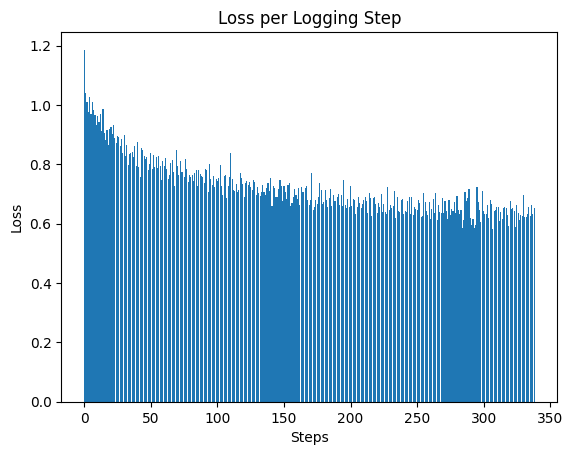

In [ ]:
plt.bar(range(len(loss_logging_callback.losses)), loss_logging_callback.losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss per Logging Step')
plt.show()

## 3. Evaluation and error analysis

We have used our **validation set** to check the model's performances during training. General result:

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 281
  Batch size = 8


0.7259786476868327
Logging at step 0: {'eval_acc': 0.7259786476868327, 'eval_loss': 0.8467274904251099, 'eval_runtime': 2.5772, 'eval_samples_per_second': 109.033, 'eval_steps_per_second': 13.969}


{'eval_acc': 0.7259786476868327,
 'eval_loss': 0.8467274904251099,
 'eval_runtime': 2.5772,
 'eval_samples_per_second': 109.033,
 'eval_steps_per_second': 13.969}

The number that you see after **"eval_acc"** is the accuracy of the model on the validation set.

In [ ]:
# Creating a text classification pipeline, using our model (with the trained adapter added)
classifier = TextClassificationPipeline(model=model, # The model to use for classification
                                        tokenizer=tokenizer, # The tokenizer to process the input text
                                        device=training_args.device.index # The device (CPU/GPU) to run the model on
                                        )

# @title Model prediction
classifier("do you know if this is true?")[0]['label'] # Use the classifier to predict the label of the given text

'query'

In [ ]:
# @title How confident is our model with its prediction:
classifier("do you know if this is true?")[0]['score']

0.9435333609580994

We are satisfied with our model's performances. **GB**: but we don't have the performance, right? only the confidence for one datapoint?

We now inspect the model's errors on our **test set**.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your classifier function outputs labels directly as 'comment', 'support', 'deny', 'query'
true_labels = []
pred_labels = []

for text, label in list(zip(df_test['input'], df_test['output'])):  # a subset for testing
    prediction = classifier(text)[0]['label']
    true_labels.append(label)
    pred_labels.append(prediction)

# Now, convert these labels into numeric form for sklearn functions
label_mapping = {'comment': 0, 'support': 1, 'deny': 2, 'query': 3}
numeric_true_labels = [label_mapping[label] for label in true_labels]
numeric_pred_labels = [label_mapping[label] for label in pred_labels]

# Generate a classification report
print(classification_report(numeric_true_labels, numeric_pred_labels, target_names=label_mapping.keys()))

# Generate a confusion matrix
conf_matrix = confusion_matrix(numeric_true_labels, numeric_pred_labels)
print(conf_matrix)
temp_dic = {'text': df_test['input'],
            'true': true_labels,
            'predicted': pred_labels}

true_pred_df = pd.DataFrame(temp_dic)
true_pred_df.to_csv("./tweets_cleaned_adapter_2_BERTtweet_clean_100e.csv")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


              precision    recall  f1-score   support

     comment       0.78      0.84      0.81       173
     support       0.62      0.55      0.58        69
        deny       0.20      0.09      0.13        11
       query       0.70      0.68      0.69        28

    accuracy                           0.73       281
   macro avg       0.58      0.54      0.55       281
weighted avg       0.71      0.73      0.72       281

[[146  19   2   6]
 [ 28  38   2   1]
 [  5   4   1   1]
 [  9   0   0  19]]
